In [2]:
from datasets import load_dataset

ds = load_dataset("thanhdath/vietnamese-sentences")
type(ds)

datasets.dataset_dict.DatasetDict

In [10]:
content = ds['train'][:]


In [11]:
type(content)

dict

In [18]:
print(ds['train'][0])

{'text': 'Không có chuyện Bùi Tiến Dũng sẽ giải nghệ sớm vì chấn thương'}


In [19]:
content = ds['train']['text']


In [20]:
content = texts

In [21]:
print(type(content))
len(content)

<class 'list'>


24739612

In [23]:
content[0]

'Không có chuyện Bùi Tiến Dũng sẽ giải nghệ sớm vì chấn thương'

In [25]:
import re
import string
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
# === 2. Xây dựng vocab và tập chunk ===

vn_dict = set()
chunks = []
list_len = []

# Nếu file có nội dung
if content:
    

    for line in content:
        # Bỏ dòng trống
        line = line.strip()
        if not line:
            continue
        
        # Tách từ + dấu câu riêng
        tokens = re.findall(r'\w+|[^\w\s]', line)

        # Làm sạch: bỏ punctuation và số
        clean_tokens = [
            tk for tk in tokens
            if tk not in string.punctuation and not is_number(tk)
        ]

        # Thêm vào từ điển
        vn_dict.update(clean_tokens)

        # Xây lại câu từ clean_tokens
        cleaned_line = ' '.join(clean_tokens)

        # Chỉ lấy chunk có số lượng từ từ 15 đến 50
        token_count = len(clean_tokens)
        if 15 <= token_count <= 50:
            chunks.append(cleaned_line)
            list_len.append(token_count)

        if len(chunks) ==100000:
            break

# === 3. In kết quả ===

print(f"Tổng số từ vựng thu được: {len(vn_dict)} từ")
print(f"Tổng số câu (chunk) thỏa mãn (15,50): {len(chunks)} câu")

Tổng số từ vựng thu được: 34331 từ
Tổng số câu (chunk) thỏa mãn (15,50): 100000 câu


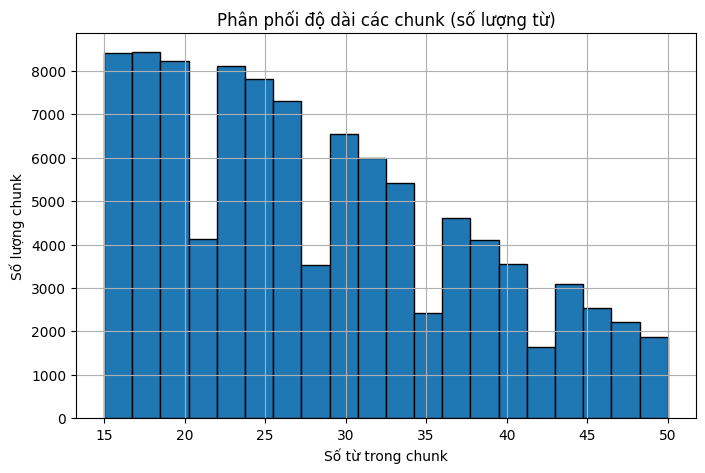

In [26]:
import matplotlib.pyplot as plt

# Vẽ histogram
plt.figure(figsize=(8, 5))
plt.hist(list_len, bins=20, edgecolor='black')

plt.title('Phân phối độ dài các chunk (số lượng từ)')
plt.xlabel('Số từ trong chunk')
plt.ylabel('Số lượng chunk')
plt.grid(True)
plt.show()


In [29]:
import random
import string

# 1. Thay thế một ký tự ngẫu nhiên trong từ
def replace_char_in_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        word = words[i]
        if random.random() < rate and len(word) > 0:
            idx = random.randint(0, len(word)-1)
            new_char = random.choice(string.ascii_letters)
            words[i] = word[:idx] + new_char + word[idx+1:]
            idx_error.append(i)
    return ' '.join(words), idx_error

# 2. Viết hoa toàn bộ từ
def upper_case_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        if random.random() < rate:
            words[i] = words[i].upper()
            idx_error.append(i)
    return ' '.join(words), idx_error

# 3. Chèn ký tự ngẫu nhiên vào vị trí ngẫu nhiên trong từ
def insert_char_in_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        word = words[i]
        if random.random() < rate:
            idx = random.randint(0, len(word))  # insert trước/sau
            insert_char = random.choice(string.ascii_letters)
            words[i] = word[:idx] + insert_char + word[idx:]
            idx_error.append(i)
    return ' '.join(words), idx_error

# 4. Xóa 1 ký tự ngẫu nhiên trong từ
def delete_char_in_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        word = words[i]
        if random.random() < rate and len(word) > 1:
            idx = random.randint(0, len(word)-1)
            words[i] = word[:idx] + word[idx+1:]
            idx_error.append(i)
    return ' '.join(words), idx_error

# 5. Đổi chỗ 2 ký tự bất kỳ trong từ
def swap_char_in_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        word = words[i]
        if random.random() < rate and len(word) > 1:
            idx1, idx2 = random.sample(range(len(word)), 2)
            word = list(word)
            word[idx1], word[idx2] = word[idx2], word[idx1]
            words[i] = ''.join(word)
            idx_error.append(i)
    return ' '.join(words), idx_error


In [33]:
import pandas as pd
import re
from tqdm import tqdm

def create_error_dataset(
    sentences,
    error_rate=0.01,
    error_module=None,
    num_sentences=5000,
    output_csv="output.csv"
):
    data = {
        'ground_truth': [],
        'corrupted': [],
        'mask': []
    }

    counter = 0
    for line in tqdm(sentences):
        if counter >= num_sentences:
            break

        line = line.strip()
        if not line:
            continue

        # Chuẩn hóa dấu câu (tách từ + dấu)
        tokens = re.findall(r'\w+|[^\w\s]', line)
        line_clean = " ".join(tokens)

        # Bỏ qua câu có nhiều dấu chấm (phức tạp)
        if '. ' in line_clean:
            continue

        corrupted_line = line_clean
        word_level_errors = set()  # lưu chỉ số từ bị lỗi

        # Áp dụng các module lỗi
        for func in error_module:
            corrupted_line, idx_err = func(corrupted_line, error_rate)
            word_level_errors.update(idx_err)

        # Tạo mask theo từ
        clean_words = line_clean.split()
        corrupted_words = corrupted_line.split()

        # Nếu số từ không trùng, bỏ qua (có thể do delete hoặc insert sai lệch)
        if len(clean_words) != len(corrupted_words):
            continue

        mask = [0] * len(corrupted_words)
        for idx in word_level_errors:
            if 0 <= idx < len(mask):
                mask[idx] = 1

        # Lưu vào dataset
        data['ground_truth'].append(line_clean)
        data['corrupted'].append(corrupted_line)
        data['mask'].append(''.join(map(str, mask)))

        counter += 1

    # Xuất ra file CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False, encoding='utf-8-sig')
    print(f"✅ Đã lưu {len(df)} câu vào {output_csv}")


In [41]:
# Các hàm lỗi muốn dùng
error_functions = [
    replace_char_in_word,
    upper_case_word,
    insert_char_in_word,
    delete_char_in_word,
    swap_char_in_word
]



# Tạo dữ liệu
create_error_dataset(
    chunks,
    error_rate=0.015,        
    error_module=error_functions,
    num_sentences=100000,
    output_csv="error_dataset.csv"
)


100%|██████████| 100000/100000 [00:05<00:00, 17091.08it/s]


✅ Đã lưu 100000 câu vào error_dataset.csv


In [43]:
data = pd.read_csv("/kaggle/working/error_test.csv")
data

,ground_truth,corrupted,mask
0,Đại diện CLB Hà Nội cho biết thủ môn Bùi Tiến ...,NĐại diện CLB Hà Nội cho biết thủ môn Bùi Tiến...,100000000000000000000000
1,Đầu mùa giải vừa qua Bùi Tiến Dũng chính thức ...,Đầu mùa giải vừa qua Bùi Tiến DũngT chính thức...,0000000100000000000000000
2,Thế nhưng tính đến nay Bùi Tiến Dũng vẫn chưa ...,Thế nhưng tính đến nay Bùi Tiến Dũng vẫn chưa ...,000000000000000000
3,Dù trước đó anh được HLV Park Hang Seo sử dụng...,Dù trước đó anh được HLV Park Hang Seo sử dụng...,000000000000000000000000000
4,Bùi Tiến Dũng gặp chấn thương ở cổ tay nhưng c...,Bùi Tiến Dũng gặp chấn thương ở cổ tay nhưng c...,000000000000000000
...,...,...,...
4995,Đi đi về về quần quật suốt ngày nhưng ông Trầm...,Đh đi ề về quần quật suốt ngày nhưng ông Trầm ...,10100000000000001
4996,Khi tích cóp được số vốn kha khá ông bắt đầu m...,Khi tích óp được số vốn kha khá ông bắt đầu mở...,00100000000000000
4997,Giữ chữ tín trong làm ăn nên ông rất được các ...,Giữ chữ tín trong làm ăn ênn ông rất được các ...,000000100000000
4998,Đơn đặt hàng từ các tỉnh phía Nam rồi Đà Nẵng ...,MĐơn đặt hàng từ các tỉnh phía Nam rồi Đà Nẵng...,100000000000000
